In [1]:
import numpy as np
import scipy
import xarray as xr
import sys
from calendar import monthrange
import os
import matplotlib.pyplot as plt
import cmocean
from scipy import stats,signal


In [2]:
#%% Define directory
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_specIdeal/"
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01/"     # This simulation has both LES (d03,d04) for at least 1 hr after spinup
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_skipCoLES_ndg/"

WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_28_skipd01_skipCoLES_ndg/"

# WRF_FILES = 'merged_d02.nc_new' 
# WRF_FILES = 'merged_d03.nc' 
# WRF_FILES = 'merged_d04.nc' 
# WRF_FILES = 'merged_d03.nc' 
WRF_FILES = 'merged_d02.nc' 



In [3]:
#%% Extract variables from file
ds=xr.open_dataset(WRF_DIRECTORY+WRF_FILES,decode_times=False)
# Wind speed
u = ds['U']
u = np.array(u[:,0,:,:,:])
v = ds['V']
v = np.array(v[:,0,:,:,:])
w = ds['W']
w = np.array(w[:,0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,:,0:np.shape(u)[3]-1]+u[:,:,:,1:np.shape(u)[3]])
u = 0.0
v_des = 0.5*(v[:,:,0:np.shape(v)[2]-1,:]+v[:,:,1:np.shape(v)[2],:])
v = 0.0
w_des = 0.5*(w[:,0:np.shape(w)[1]-1,:,:]+w[:,1:np.shape(w)[1],:,:])
w = 0.0
# Calculate horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
# Potential temperature
t = ds['T']
theta = np.array(t[:,0,:,:,:]) + 300
# t_skin = ds['TSK']
# t_skin = np.array(t_skin[:,0,:,:]) 
#t_skin = np.mean(np.mean(t_skin,axis=1),axis=1)
# Time
Time = ds['Times']
Time = np.array(Time)
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[3])
n_y = dx*np.arange(0,np.shape(uv)[2])
# Time step
DT = ds.DT
ds.close()

# Extract height variables
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
#     if WRF_FILES[7:10] in entries[i]:
    if 'wrfrst' in entries[i]:
        ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)
ds=xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
ph = ds['PH_1']
ph = np.array(ph[0,:,:,:])
phb = ds['PHB']
phb = np.array(phb[0,:,:,:])
height_stag = (np.mean(ph,axis=(1,2))+np.mean(phb,axis=(1,2)))/9.81
height_agl = 0.5*(height_stag[1:] + height_stag[0:-1])
if len(height_agl)!=np.shape(uv)[1]:
    height_agl = height_agl[0:np.shape(uv)[1]]
    height_stag = height_agl[0:np.shape(uv)[1]+1]
ds.close()

# Turbine specifications
D = 126
z_hh = 90
rated_ws = 11.4

print("done extracting variables")

done extracting variables


In [4]:
#%% Create time vector (after initialization) (ignore dates)
# Create large datetime64 array
ttime = np.arange('2000-01-01T00:00:00', '2000-01-02T00:00:00',np.shape(Time)[0], dtype='datetime64')
# Save actual times for simulation
for i_t in np.arange(0,np.shape(Time)[0]):
    a = str(Time[i_t])
    ttime[i_t] = np.datetime64(a[3:13] + str(' ')+ a[14:-2])
    # ttime[i_t] = ttime[0] + np.timedelta64(5*60,dtype='datetime64[s]')*i_t
# Save portion of temp array that actually matters
ttime = ttime[0:np.shape(Time)[0]]

print(ttime)

['2000-01-06T10:00:30' '2000-01-06T10:01:30' '2000-01-06T10:02:30'
 '2000-01-06T10:03:30' '2000-01-06T10:04:30' '2000-01-06T10:05:30'
 '2000-01-06T10:06:30']


In [5]:
#%% Sort arrays by time
i_sort = np.argsort(ttime)
uv = uv[i_sort,:,:,:]
u_des = u_des[i_sort,:,:,:]
v_des = v_des[i_sort,:,:,:]
w_des = w_des[i_sort,:,:,:]
theta = theta[i_sort,:,:,:]
ttime = ttime[i_sort]


In [6]:
#%% Time since initialization
t_init = np.datetime64('2000-01-01T00:00:10')

time_sinceInit = ttime - t_init
time_sinceInit = time_sinceInit.astype('timedelta64[s]')

t_since = time_sinceInit.astype('float')/3600 # [hr]


In [7]:
np.min(height_agl[1:] - height_agl[0:-1])

22.169205

In [8]:
#%% Maximum time step
max_dt_op1 = dx/((np.max(uv)**2 + np.max(np.abs(w_des))**2)**0.5)
max_dt_op2 = (dx**2 + np.min(height_stag[1:] - height_stag[0:-1])**2)**0.5/((np.max(uv)**2 + np.max(np.abs(w_des))**2)**0.5)
max_dt_op3 = np.min(height_stag[1:] - height_stag[0:-1])/np.max(np.abs(w_des))


print('Max. dt is between %f s, %f s, and %f s'% (max_dt_op1/3, max_dt_op2/3, max_dt_op3/3))
print('Current dt is %f s' % DT)

if np.min([max_dt_op1,max_dt_op2,max_dt_op3])/3 < DT:
    print("CHECK TIME STEP!!!")
    stop

Max. dt is between 0.203911 s, 0.219546 s, and 0.407285 s
Current dt is 0.060185 s


In [9]:
dd = height_stag[1:] - height_stag[0:-1]
print(dd[15:21])

[]


In [10]:
40/np.max(np.abs(w_des))/3

0.7348655132392002

In [11]:
#%% Find hub-height
i_hh = np.argmin(np.abs(height_agl - z_hh))


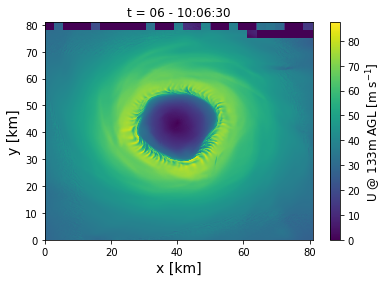

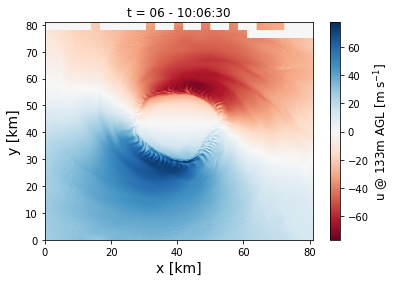

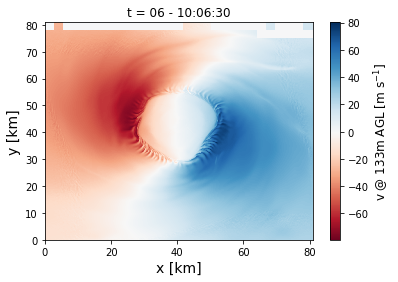

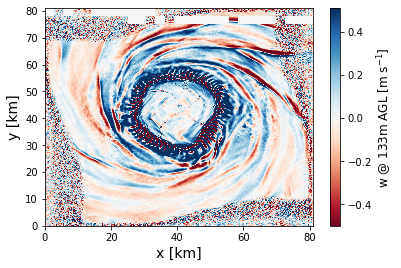

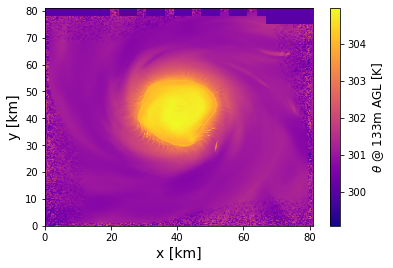

In [12]:
#%% Plot wind speed at one height
iz = np.min([9,len(height_agl)-1])#np.argmin(np.abs(height_agl - z_hh))
it = -1

# Horizontal wind speed
plt.figure(figsize=(6,4))
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[it,iz,:,:])
cbar = plt.colorbar(im1)
cbar.set_label('U @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.scatter(n_x[4]/1000,n_y[4]/1000,color='r')
#if 'merged_d05.nc' in WRF_FILES:
#    plt.scatter(n_x[locs_ts[:,0]]/1000,n_y[locs_ts[:,1]]/1000,s=5,color='red')
#plt.xlim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(143*dx/1000,(143*dx + 403*4500)/1000)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()


# Zonal wind speed
plt.figure(figsize=(6,4))
u_des[it,iz,0,0] = 0.5
u_des[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(u_des[it,iz,:,:]), np.max(u_des[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,u_des[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('u @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(2000,4000)
#plt.xlim(2000,4000)
plt.show()
plt.close()

# Meridional wind speed
plt.figure(figsize=(6,4))
v_des[it,iz,0,0] = 0.5
v_des[it,iz,0,1] = -0.5
newCmap = cmocean.tools.crop(plt.cm.RdBu, np.min(v_des[it,iz,:,:]), np.max(v_des[it,iz,:,:]), 0)
plt.title('t = '+str(ttime[it])[8:10]+' - '+str(ttime[it])[11:])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,v_des[it,iz,:,:],cmap=newCmap)
cbar = plt.colorbar(im1)
cbar.set_label('v @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000/1000,600000/1000)
#plt.xlim(400000/1000,600000/1000)
plt.show()
plt.close()


# Vertical wind speed
plt.figure(figsize=(6,4))
minn = -0.5# np.min(w_des[it,iz,:,:])
maxx = 0.51 #np.max(w_des[it,iz,:,:])
newCmap = cmocean.tools.crop(plt.cm.RdBu, minn, maxx, 0)
im1 = plt.pcolormesh(n_x/1000,n_y/1000,w_des[it,iz,:,:],cmap=newCmap,vmin=minn,vmax=maxx)
cbar = plt.colorbar(im1)
cbar.set_label('w @ ' + str(int(height_agl[iz])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()


# Potential temperature
plt.figure(figsize=(6,4))
im1 = plt.pcolormesh(n_x/1000,n_y/1000,theta[it,iz,:,:],cmap=plt.cm.plasma)
cbar = plt.colorbar(im1)
cbar.set_label(r'$\theta$ @ ' + str(int(height_agl[iz])) + 'm AGL [K]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
#plt.ylim(400000,600000)
#plt.xlim(400000,600000)
plt.show()
plt.close()



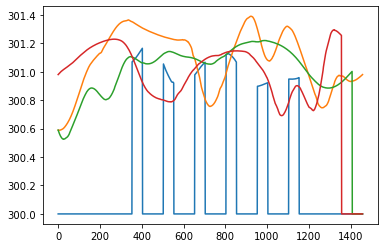

In [13]:
#%% Boundary conditions
it = -1
iz = -1

plt.figure()
plt.plot(theta[it,iz,-1,:])
plt.plot(theta[it,iz,0,:])
# plt.plot(theta[it,iz,-1,:])
# plt.plot(0*theta[it,iz,0,:] + theta[0,iz,0,:])
plt.plot(theta[it,iz,:,0])
plt.plot(theta[it,iz,:,-1])

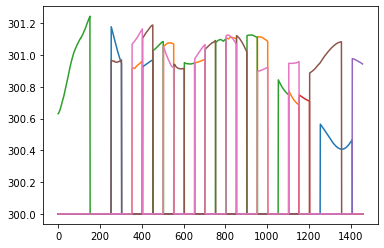

In [14]:
plt.figure()
for iitt in np.arange(len(ttime)):
    plt.plot(theta[iitt,iz,-1,:])

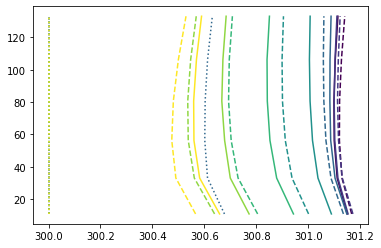

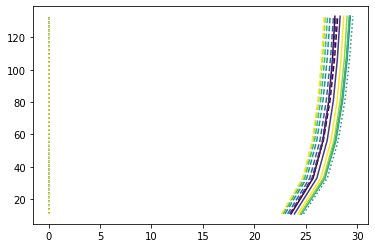

In [15]:
cols = plt.cm.viridis(np.linspace(0,1,len(ttime)))
plt.figure()
for iitt in np.arange(len(ttime)):
    plt.plot(theta[iitt,:,0,0],height_agl,color=cols[iitt])
    plt.plot(theta[iitt,:,-1,0],height_agl,color=cols[iitt],linestyle=':')
    plt.plot(theta[iitt,:,20,0],height_agl,color=cols[iitt],linestyle='--')
    
    
plt.figure()
for iitt in np.arange(len(ttime)):
    plt.plot(uv[iitt,:,0,0],height_agl,color=cols[iitt])
    plt.plot(uv[iitt,:,-1,0],height_agl,color=cols[iitt],linestyle=':')
    plt.plot(uv[iitt,:,0,-1],height_agl,color=cols[iitt],linestyle='--')

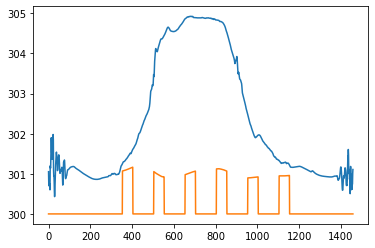

In [16]:
plt.plot(theta[it,iz,int(0.5*np.shape(theta)[2]),:])
plt.plot(theta[it,iz,-1,:])

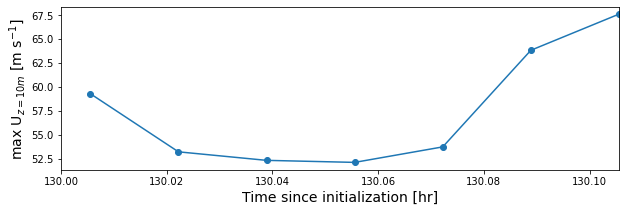

[130.00555556 130.02222222 130.03888889 130.05555556 130.07222222
 130.08888889 130.10555556]
[59.28091812 53.20905304 52.31801224 52.10599518 53.72554398 63.81978607
 67.5953064 ]


In [19]:
#%% Maximum velocity at the surface
temp_uv = np.zeros(np.shape(uv[:,0,:,:])) + uv[:,0,:,:]
temp_uv[:,0:10,:] = np.nan
temp_uv[:,-10:,:] = np.nan
temp_uv[:,:,0:10] = np.nan
temp_uv[:,:,-10:] = np.nan

max_uv_s = np.nanmax(temp_uv[:,:,:],axis=(1,2))

# Using spec_ideal == 1 (d01)
tt = np.array([1.38888889e-02, 5.01388889e+00, 1.00138889e+01, 1.50138889e+01, 2.00138889e+01, 2.40138889e+01, 2.90138889e+01])
uu = np.array([13.54788876, 11.08468342, 10.87518215, 10.75202084, 11.08902264, 11.82450104, 14.53823471])

# Former SST 26 C simulations (d01)
tt = np.array([  0.,   5.,  10.,  15.,  24.,  29.,  34.,  39.,  48.,  53.,  58.,
        63.,  72.,  77.,  82.,  87.,  96., 101., 106., 111., 120., 125.,
       130., 135., 144., 149., 154., 159.])
uu = np.array([13.54828262,  8.77157402,  9.45457554, 11.27740669, 11.9268198 ,
       13.16132927, 13.75687599, 13.1161623 , 15.76303291, 15.42835808,
       17.27808952, 21.57518387, 23.26102257, 25.62145615, 27.79660034,
       26.43683624, 29.14901924, 28.98266029, 28.88020706, 31.26420212,
       29.68917656, 27.73842621, 27.33545113, 27.90090561, 27.03103638,
       28.23969841, 27.88521194, 27.92738342])

plt.figure(figsize=(10,3))
plt.plot(t_since[:],max_uv_s[:],'-o',zorder=0) #,label='XLAND == 2')
# plt.scatter(t_since[-14],max_uv_s[-14],color='tab:orange',zorder=1) #,label='XLAND == 2')
# plt.scatter(t_since[-12],max_uv_s[-12],color='tab:orange',zorder=1) #,label='XLAND == 2')
# plt.plot(tt,uu,label='XLAND == 1')
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'max U$_{z=10m}$ [m s$^{-1}$]',fontsize=14)
plt.xlim(int(t_since[0]),t_since[-1])
# plt.legend()
plt.show()
plt.close()


# print(np.nanmean(temp_uv[-4]))
# print(ttime[-12])

print(t_since)
print(max_uv_s)



In [20]:
# np.mean(t_skin,axis=(-2,-1)) - 273.15

ix_max = 486; iy_max = 635
ix_max = 516; iy_max = 561
ix_max = 507; iy_max = 601
ix_max = 979; iy_max = 659
ix_max = 559; iy_max = 941
ix_max = 532; iy_max = 660
ix_max = 822; iy_max = 555


(0.0, 133.06788635253906)

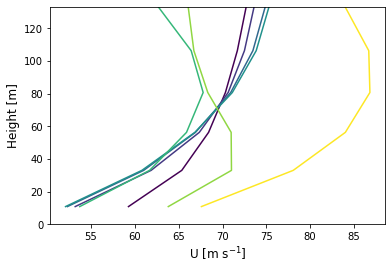

In [21]:
#%% Vertical profile of maximum wind speed
x_grid,y_grid = np.meshgrid(n_x,n_y)

z_max = height_agl[-1]
col = plt.cm.viridis(np.linspace(0,1,np.shape(theta)[0]))

plt.figure()
for it in np.arange(np.shape(theta)[0]):
    temp_uv = np.zeros(np.shape(uv[it,0,:,:])) + uv[it,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    uv_flat = np.reshape(temp_uv,[len(n_x)*len(n_y)])
    nx_flat = np.reshape(x_grid[:,:],[len(n_x)*len(n_y)])
    ny_flat = np.reshape(y_grid[:,:],[len(n_x)*len(n_y)])
    max_ws_ref = np.argmax(uv_flat)
    ix_max = np.argmin(np.abs(nx_flat[max_ws_ref] - n_x))
    iy_max = np.argmin(np.abs(ny_flat[max_ws_ref] - n_y))
    print('ix_max = '+str(ix_max) + '; iy_max = '+str(iy_max))
    plt.plot(uv[it,:,iy_max,ix_max],height_agl,color=col[it],label='t = '+str(ttime[it])[8:])
plt.xlabel(r'U [m s$^{-1}$]',fontsize=12)
plt.ylabel(r'Height [m]',fontsize=12)
plt.ylim(0,z_max)
# plt.legend()


In [22]:
np.shape(theta)

(7, 6, 1458, 1458)

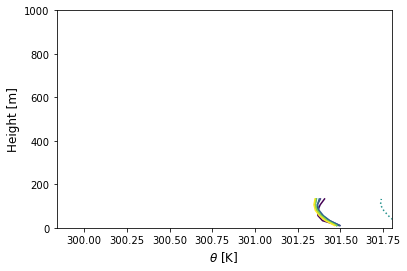

In [23]:
#%% Domain average potential temperature evolution
theta_avg_sp = np.mean(theta,axis=(2,3))
z_max = 1000 #1500

plt.figure()
for it in np.arange(np.shape(theta)[0]):
    plt.plot(theta_avg_sp[it,:],height_agl,color=col[it],label='t = '+str(ttime[it])[8:])
    # Location with max wind speed
    temp_uv = np.zeros(np.shape(uv[it,0,:,:])) + uv[it,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    uv_flat = np.reshape(temp_uv,[len(n_x)*len(n_y)])
    nx_flat = np.reshape(x_grid[:,:],[len(n_x)*len(n_y)])
    ny_flat = np.reshape(y_grid[:,:],[len(n_x)*len(n_y)])
    max_ws_ref = np.argmax(uv_flat)
    ix_max = np.argmin(np.abs(nx_flat[max_ws_ref] - n_x))
    iy_max = np.argmin(np.abs(ny_flat[max_ws_ref] - n_y))
    plt.plot(theta[it,:,iy_max,ix_max],height_agl,color=col[it],linestyle=':')
plt.xlabel(r'$\theta$ [K]',fontsize=12)
plt.ylabel(r'Height [m]',fontsize=12)
plt.ylim(0,z_max)
plt.xlim(0.995*np.min(theta_avg_sp),1.001*np.max(theta_avg_sp[:,height_agl<z_max]))
# plt.legend()
plt.show()
plt.close()



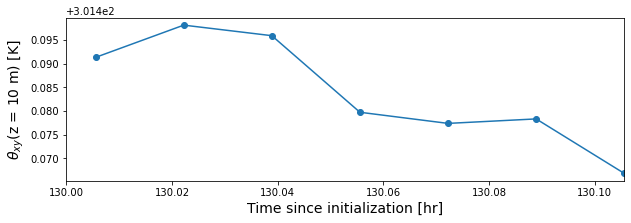

In [24]:
#%% Time series of temperature of air at lowest vertical level

thth = np.array([294.80072, 296.4221 , 296.59338, 296.50067, 296.52856, 296.53613,
       296.5473 , 296.54752, 296.55054, 296.5484 , 296.5364 , 296.53085,
       296.51797, 296.50977, 296.50748, 296.50363, 296.48083, 296.47388,
       296.46933, 296.46823, 296.4496 , 296.4479 , 296.44437, 296.441  ,
       296.43716, 296.4352 , 296.43457, 296.435  ])

plt.figure(figsize=(10,3))
plt.plot(t_since[:],theta_avg_sp[:,0],'-o')
# plt.plot(tt,thth)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'$\theta_{xy}$(z = 10 m) [K]',fontsize=14)
plt.xlim(int(t_since[0]),t_since[-1])
plt.show()
plt.close()



In [25]:
#%% Find center of hurricane based on minimum wind speed
center = np.zeros([len(ttime),2]) + np.nan # [x,y]

X_grid,Y_grid = np.meshgrid(n_x,n_y)
X_grid = X_grid.flatten()
Y_grid = Y_grid.flatten()

for iitt in np.arange(np.shape(uv)[0]):
    
    temp_uv = np.zeros(np.shape(uv[iitt,0,:,:])) + uv[iitt,0,:,:]
    temp_uv[0:10,:] = np.nan
    temp_uv[-10:,:] = np.nan
    temp_uv[:,0:10] = np.nan
    temp_uv[:,-10:] = np.nan
    uv_flat = temp_uv.flatten() #uv[-1,0,:,:].flatten()
    uv_flat[np.isnan(uv_flat)] = 0
    max_ws_ref = np.argmax(uv_flat)
    if 'd03' in WRF_FILES:
        temp_uv = np.zeros(np.shape(uv[iitt,0,:,:])) + uv[iitt,0,:,:]
        temp_uv[0:200,:] = np.nan
        temp_uv[-200:,:] = np.nan
        temp_uv[:,0:200] = np.nan
        temp_uv[:,-200:] = np.nan
        uv_flat = temp_uv.flatten() #uv[-1,0,:,:].flatten()
        max_ws_ref = np.nanargmin(uv_flat)
    
    if 'd01' in WRF_FILES:
        lim_low_x = np.mean(n_x) - 0.1*n_x[-1]
        lim_low_y = np.mean(n_x) - 0.1*n_x[-1]
        lim_high_x = np.mean(n_x) + 0.1*n_x[-1]
        lim_high_y = np.mean(n_x) + 0.1*n_x[-1]
#         if iitt==0:
# #             lim_low_x = 1950*1000# X_grid[max_ws_ref] - 0.05*np.mean(n_x)
# #             lim_low_y = 1950*1000# Y_grid[max_ws_ref] - 0.05*np.mean(n_y)
# #             lim_high_x = 2050*1000# X_grid[max_ws_ref] + 0.05*np.mean(n_x)
# #             lim_high_y = 2050*1000# Y_grid[max_ws_ref] + 0.05*np.mean(n_y)
#             lim_low_x = np.mean(n_x) - 0.4*np.mean(n_x)
#             lim_low_y = np.mean(n_y) - 0.4*np.mean(n_y)# - 50*1000
#             lim_high_x = np.mean(n_x) + 0.4*np.mean(n_x)
#             lim_high_y = np.mean(n_y) + 0.4*np.mean(n_y)
#         else:
#             lim_low_x = center[iitt-1,0] - 0.5*(lim_high_x-lim_low_x)
#             lim_low_y = center[iitt-1,1] - 0.5*(lim_high_y-lim_low_y)
#             lim_high_x = center[iitt-1,0] + 0.5*(lim_high_x-lim_low_x)
#             lim_high_y = center[iitt-1,1] + 0.5*(lim_high_y-lim_low_y)
    elif 'd02' in WRF_FILES:
#         lim_low_x = np.mean(n_x) - 0.3*np.mean(n_x)
#         lim_low_y = np.mean(n_y) - 0.2*np.mean(n_y)# - 50*1000
#         lim_high_x = np.mean(n_x) + 0.1*np.mean(n_x)
#         lim_high_y = np.mean(n_y) + 0.1*np.mean(n_y)
        lim_low_x = X_grid[max_ws_ref] - 0.4*np.mean(n_x)
        lim_low_y = Y_grid[max_ws_ref] - 0.4*np.mean(n_y)
        lim_high_x = X_grid[max_ws_ref] + 0.4*np.mean(n_x)
        lim_high_y = Y_grid[max_ws_ref] + 0.4*np.mean(n_y)
    elif 'd03' in WRF_FILES:
        if iitt==0:
            lim_low_x = X_grid[max_ws_ref] - 0.1*np.mean(n_x)
            lim_low_y = Y_grid[max_ws_ref] - 0.1*np.mean(n_y)
            lim_high_x = X_grid[max_ws_ref] + 0.1*np.mean(n_x)
            lim_high_y = Y_grid[max_ws_ref] + 0.1*np.mean(n_y)  
        else:
            lim_low_x = center[iitt-1,0] - 10000
            lim_low_y = center[iitt-1,1] - 10000
            lim_high_x = center[iitt-1,0] + 10000
            lim_high_y = center[iitt-1,1] + 10000
    else:# 'd04' in WRF_FILES:
#        lim_low_x = X_grid[max_ws_ref] - 0.5*np.mean(n_x)
#        lim_low_y = Y_grid[max_ws_ref] - 0.3*np.mean(n_y)
#        lim_high_x = X_grid[max_ws_ref] + 0.3*np.mean(n_x)
#        lim_high_y = Y_grid[max_ws_ref] + 0.3*np.mean(n_y) 
        lim_low_x = 0.3*np.max(n_x)
        lim_low_y = 0.3*np.max(n_y)
        lim_high_x = 0.6*np.max(n_x)
        lim_high_y = 0.6*np.max(n_x)
        
    # Create small meshgrid
    small_x,small_y = np.meshgrid(n_x[(n_x<lim_high_x)&(n_x>lim_low_x)],n_y[(n_y<lim_high_y)&(n_y>lim_low_y)])
    flat_smallX = small_x.flatten()
    flat_smallY = small_y.flatten()

    # Crop array
    temp_uv_1 = uv[iitt,0,(n_y<lim_high_y)&(n_y>lim_low_y),:]
    temp_uv_2 = temp_uv_1[:,(n_x<lim_high_x)&(n_x>lim_low_x)]
    # Flatten array
    temp_uv_flat = temp_uv_2.flatten()
    # Find location of minimum
    if np.any(temp_uv_flat)==True:
        i_min = np.argmin(temp_uv_flat)
        # Save location of minimum
        center[iitt,0] = flat_smallX[i_min]
        center[iitt,1] = flat_smallY[i_min]
    else:
        # Save location of minimum
        center[iitt,0] = np.mean(n_x)
        center[iitt,1] = np.mean(n_y)

In [26]:
center

array([[40277.80942917, 43777.81217957],
       [40333.36502838, 43833.36777878],
       [40333.36502838, 43777.81217957],
       [40277.80942917, 43777.81217957],
       [40166.69823074, 43722.25658035],
       [40055.58703232, 43611.14538193],
       [39944.47583389, 43500.0341835 ]])

In [27]:
#%% Get geometrical center using velocity contours
slow_winds = [5,7,9]
slow_winds = [5,10,15]
geo_center2 = np.zeros([len(ttime),len(slow_winds),2])

dyn_center = center
for iitt in np.arange(len(ttime)):
    ## Limits on what to plot
    lim_low_x = dyn_center[iitt,0] - 0.3*np.mean(n_x)
    lim_low_y = dyn_center[iitt,1] - 0.3*np.mean(n_y)
    lim_high_x = dyn_center[iitt,0] + 0.3*np.mean(n_x)
    lim_high_y = dyn_center[iitt,1] + 0.3*np.mean(n_y)
    
    
    # Get contours for a set of slow wind speeds close to the hurricane center
    small_x = n_x[(n_x>lim_low_x) & (n_x<lim_high_x)]
    small_y = n_y[(n_y>lim_low_y) & (n_y<lim_high_y)]
    small_uv = uv[iitt,iz,(n_y>lim_low_y) & (n_y<lim_high_y),:]
    small_uv = small_uv[:,(n_x>lim_low_x) & (n_x<lim_high_x)]
    cs = plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds)
    paths = cs.collections
    plt.close()
    
#    plt.figure()
#    plt.contourf(small_x/1000,small_y/1000,small_uv)
#    plt.contour(small_x/1000,small_y/1000,small_uv, slow_winds,cmap=plt.cm.binary)
#    plt.show()
    
    # Get vertices of contours for each wind speed
    for i_ws in np.arange(len(slow_winds)):
        allP = paths[i_ws].get_paths()
        # Find longest path
        longest = 0
        len_longest = 0
        if len(allP)>0:
            for i_p in np.arange(len(allP)):
                if len(allP[i_p]) > len_longest:
                    longest = i_p
                    len_longest = len(allP[i_p])
            path = allP[longest]
            verts = path.vertices
            x_contour = verts[:,0]
            y_contour = verts[:,1]
            geo_center2[iitt,i_ws,0] = np.mean(x_contour)*1000
            geo_center2[iitt,i_ws,1] = np.mean(y_contour)*1000
        

In [28]:
#%% Choose which method for finding the center
meth_cent = 'oth'
if meth_cent=='geo':
    temp_cent = np.zeros_like(geo_center2[:,1,:]) + geo_center2[:,2,:] + 0.0
else:
    temp_cent = np.zeros_like(center) + center + 0.0


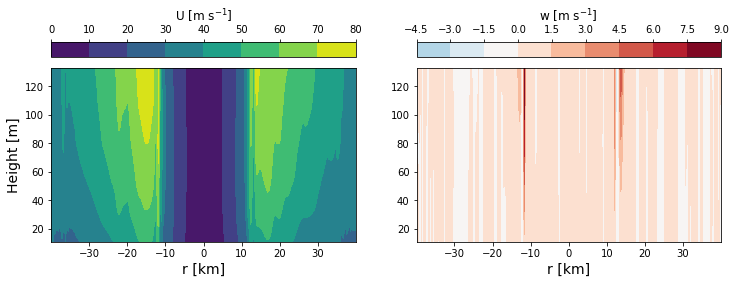

In [29]:
#%% Slice of horizontal and vertical velocity for hurricane
it = -1

r_x = (n_x - temp_cent[-1,0])/1000
xx_lim = np.min([-1*np.min(r_x),np.max(r_x)])

fig,axs = plt.subplots(1,2,figsize=(12,4))
# Horizontal velocity
im1 = axs[0].contourf(r_x,height_agl,uv[it,:,int(temp_cent[it,1]/dx),:])
axs[0].set_xlim(-1*xx_lim,xx_lim)
axs[0].set_xlabel('r [km]',fontsize=14)
axs[0].set_ylabel('Height [m]',fontsize=14)
cbar1 = fig.colorbar(im1, ax=[axs[0]], location='top')
cbar1.set_label(r'U [m s$^{-1}$]',fontsize=12)

# Vertical velocity
newCmap = cmocean.tools.crop(plt.cm.RdBu_r, np.min(w_des[it,:,int(temp_cent[it,1]/dx),:]), np.max(w_des[it,:,int(temp_cent[it,1]/dx),:]), 0)
im2 = axs[1].contourf(r_x,height_agl,w_des[it,:,int(temp_cent[it,1]/dx),:],cmap=newCmap)
axs[1].set_xlim(-1*xx_lim,xx_lim)
axs[1].set_xlabel('r [km]',fontsize=14)
cbar2 = fig.colorbar(im2, ax=[axs[1]], location='top')
cbar2.set_label(r'w [m s$^{-1}$]',fontsize=12)

#plt.tight_layout()
plt.show()
plt.close()  

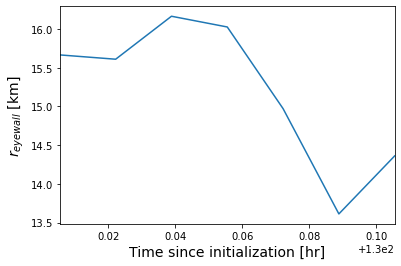

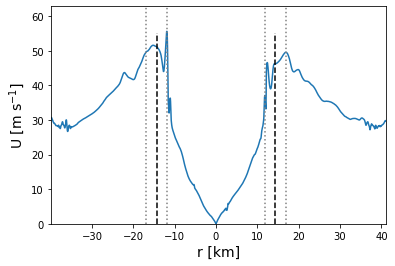

[15666.67897797 15611.12337875 16166.67937088 16027.79037285
 14972.23398781 13611.1218071  14361.12239647]
15202.39289883205


In [30]:
#%% Find radius of eyewall in hurricane
r_eye = np.zeros(np.shape(ttime))
r1 = np.zeros(np.shape(ttime))
r2 = np.zeros(np.shape(ttime))

# Find radius of eyewall for each time
for ii in np.arange(len(ttime)):
    temp_uv = np.zeros(np.shape(uv[ii,0,:,:])) + uv[ii,0,:,:]
    temp_uv[0:10,:] = 0
    temp_uv[-10:,:] = 0
    temp_uv[:,0:10] = 0
    temp_uv[:,-10:] = 0
    
    i_r_max1 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),int(temp_cent[ii,0]/dx):])
    i_r_max2 = np.argmax(temp_uv[int(temp_cent[ii,1]/dx),0:int(temp_cent[ii,0]/dx)])
    r1[ii] = np.abs(n_x[int(temp_cent[ii,0]/dx):][i_r_max1] - temp_cent[ii,0])
    r2[ii] = np.abs(n_x[0:int(temp_cent[ii,0]/dx)][i_r_max2] - temp_cent[ii,0])
    r_eye[ii] = 0.5*(r1[ii] + r2[ii])

# Temporal evolution of hurricane eyewall
plt.figure()
plt.plot(t_since,r_eye/1000)
plt.xlabel('Time since initialization [hr]',fontsize=14)
plt.ylabel(r'$r_{eyewall}$ [km]',fontsize=14)
plt.xlim(t_since[0],t_since[-1])
plt.show()
plt.close() 

# Plot of wind speed
it = -1
plt.figure()
plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:])
plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,50+5],'--k')
plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,50+5],'--k')

plt.plot(np.array([-1*r1[it],-1*r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([-1*r2[it],-1*r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.plot(np.array([r1[it],r1[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')
plt.plot(np.array([r2[it],r2[it]])/1000,[0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5],':',color='grey')

plt.xlim(np.min((n_x - center[it,0])/1000),np.max((n_x - center[it,0])/1000))
plt.xlim(np.max([-200,r_x[0]]),np.min([200,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close()  

print(r_eye)
print(np.mean(r_eye[t_since>124]))


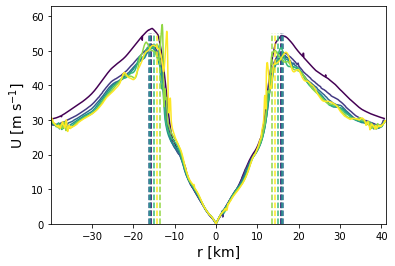

In [31]:
#%% Evolution of radius of maximum winds
cols = plt.cm.viridis(np.linspace(0,1,len(ttime)))
plt.figure()
for it in np.arange(len(ttime)):
    plt.plot((n_x-center[it,0])/1000,uv[it,0,int(temp_cent[it,1]/dx),:],color=cols[it])
    plt.plot(np.array([r_eye[it],r_eye[it]])/1000,[0,50+5],'--',color=cols[it])
    plt.plot(np.array([-1*r_eye[it],-1*r_eye[it]])/1000,[0,50+5],'--',color=cols[it])

plt.xlim(np.min((n_x - temp_cent[it,0])/1000),np.max((n_x - temp_cent[it,0])/1000))
plt.xlim(np.max([-350,r_x[0]]),np.min([350,r_x[-1]]))
plt.ylim(0,np.max(uv[:,0,int(temp_cent[it,1]/dx),:])+5)
plt.xlabel('r [km]',fontsize=14)
plt.ylabel('U [m s$^{-1}$]',fontsize=14)
plt.show()
plt.close() 


In [32]:
# ttime[-8:-5]
ttime

array(['2000-01-06T10:00:30', '2000-01-06T10:01:30',
       '2000-01-06T10:02:30', '2000-01-06T10:03:30',
       '2000-01-06T10:04:30', '2000-01-06T10:05:30',
       '2000-01-06T10:06:30'], dtype='datetime64[s]')

In [33]:
# center[-8:-5,:]
center

array([[40277.80942917, 43777.81217957],
       [40333.36502838, 43833.36777878],
       [40333.36502838, 43777.81217957],
       [40277.80942917, 43777.81217957],
       [40166.69823074, 43722.25658035],
       [40055.58703232, 43611.14538193],
       [39944.47583389, 43500.0341835 ]])

In [34]:
locs = np.loadtxt(WRF_DIRECTORY+'tslist',skiprows=3,usecols=(2,3))
locs = locs.astype('int')

/projects/misa5952/software/anaconda/envs/env_forWRF/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/projects/misa5952/software/anaconda/envs/env_forWRF/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

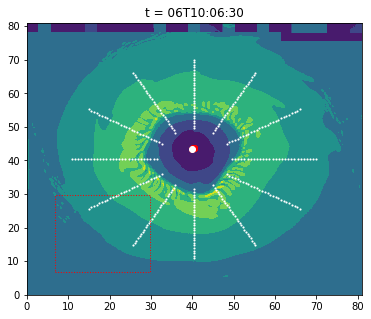

In [35]:
#%% Relative location of nest within parent domain
plt.figure(figsize=(6,5))
it = -1 #np.argmin(np.abs(ttime - np.datetime64('2000-01-05T00:00:00')))
plt.title('t = '+str(ttime[it])[8:])
# im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[it,0,:,:])
im1 = plt.contourf(n_x/1000,n_y/1000,uv[it,0,:,:])
if WRF_FILES == 'merged_d01.nc':
    dx_nest = dx/9
    nx = 657
    ix = int(temp_cent[it,0]/dx - 0.5*nx*dx_nest/dx)
    iy = int(temp_cent[it,1]/dx - 0.5*nx*dx_nest/dx)
    
    dx_nest = dx/9/3
    nx = 1458
    ix = int(temp_cent[it,0]/dx - 0.5*nx*dx_nest/dx)
    iy = int(temp_cent[it,1]/dx - 0.5*nx*dx_nest/dx)
#     ix = int(center[it,0]/dx - 0.5*nx*dx_nest/dx)
#     iy = int(center[it,1]/dx - 0.5*nx*dx_nest/dx)
    plt.fill((np.array([ix*dx,ix*dx + nx*dx_nest,ix*dx + nx*dx_nest,ix*dx])-1)/1000,np.array([iy*dx,iy*dx,iy*dx + nx*dx_nest,iy*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='r',linestyle=':',label='d02')
# elif 'merged_d02.nc' in WRF_FILES:
#     dx_nest = dx/9
#     nx = 657 # 321
#     ix = int(temp_cent[it,0]/dx - 0.5*nx*dx_nest/dx)
#     iy = int(temp_cent[it,1]/dx - 0.5*nx*dx_nest/dx)
#     plt.fill((np.array([ix*dx,ix*dx + nx*dx_nest,ix*dx + nx*dx_nest,ix*dx])-1)/1000,np.array([iy*dx,iy*dx,iy*dx + nx*dx_nest,iy*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='r',linestyle=':',label='d03')
elif 'merged_d02.nc' in WRF_FILES:
    dx_nest = dx/3
    nx = 1250#1200
    ix = 120 #int(temp_cent[it,0]/dx - 0.5*nx*dx_nest/dx)
    iy = 120 #int(temp_cent[it,1]/dx - 0.5*nx*dx_nest/dx)
    if 'sst_34' in WRF_DIRECTORY:
        nx = 1600
        ix = center[it,0]/dx - 0.5*nx*dx_nest/dx # 360
        iy = center[it,1]/dx - 0.5*nx*dx_nest/dx # 325
    plt.fill((np.array([ix*dx,ix*dx + nx*dx_nest,ix*dx + nx*dx_nest,ix*dx])-1)/1000,np.array([iy*dx,iy*dx,iy*dx + nx*dx_nest,iy*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='r',linestyle=':',label='d03')
plt.scatter(temp_cent[:,0]/1000,temp_cent[:,1]/1000,color='red')#,markersize=3,'o-')

# plt.scatter(np.mean(center[:,0]/1000),np.mean(center[:,1]/1000),s=5,c='white',marker='+')
plt.scatter(center[it,0]/1000,center[it,1]/1000,s=5,c='red',marker='o')
plt.scatter(geo_center2[it,0,0]/1000,geo_center2[it,0,1]/1000,s=15,c='orange',marker='+')
plt.scatter(temp_cent[it,0]/1000,temp_cent[it,1]/1000,color='white')#,markersize=3,'o-')

# aa = np.mean(geo_center2[:,:,:]/1000,axis=1)
# plt.scatter(aa[0][0],aa[0][1],color='black')#,markersize=3,'o-')

for i_s in np.arange(np.shape(locs)[0]):
    plt.scatter(n_x[locs[i_s,0]]/1000,n_y[locs[i_s,1]]/1000,color='white',marker='.',s=5)#,markersize=3,'o-')


# ix_avg = 129#+1 #int(np.median(temp_cent[-2:,0])/dx - 0.5*nx*dx_nest/dx)+2-1
# iy_avg = 133#+1 #int(np.median(temp_cent[-2:,1])/dx - 0.5*nx*dx_nest/dx)-2+1+4-1
# plt.fill((np.array([ix_avg*dx,ix_avg*dx + nx*dx_nest,ix_avg*dx + nx*dx_nest,ix_avg*dx])-1)/1000,np.array([iy_avg*dx,iy_avg*dx,iy_avg*dx + nx*dx_nest,iy_avg*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='white',linestyle=':',label='d02')
# print('ix_avg = '+str(ix_avg)+'; iy_avg = '+str(iy_avg))

ix_avg = int(np.median(temp_cent[-14:-12,0])/dx - 0.5*nx*dx_nest/dx)
iy_avg = int(np.median(temp_cent[-14:-12,1])/dx - 0.5*nx*dx_nest/dx)
plt.fill((np.array([ix_avg*dx,ix_avg*dx + nx*dx_nest,ix_avg*dx + nx*dx_nest,ix_avg*dx])-1)/1000,np.array([iy_avg*dx,iy_avg*dx,iy_avg*dx + nx*dx_nest,iy_avg*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='orange',linestyle=':',label='d02')

# ix_avg = int(0.5*(113 + 137))
# iy_avg = int(0.5*(118 + 166))
# plt.fill((np.array([ix_avg*dx,ix_avg*dx + nx*dx_nest,ix_avg*dx + nx*dx_nest,ix_avg*dx])-1)/1000,np.array([iy_avg*dx,iy_avg*dx,iy_avg*dx + nx*dx_nest,iy_avg*dx + nx*dx_nest])/1000,facecolor='none',edgecolor='red',linestyle='-',label='d02')


#plt.fill(n_x[np.array([305,341,341,305])]/1000,n_y[np.array([421,421,448,448])]/1000,facecolor='none',edgecolor='r',linestyle=':',label='d04')
plt.legend()
cbar = plt.colorbar(im1)
cbar.set_label('U @ ' + str(int(height_agl[0])) + 'm AGL [m s$^{-1}$]',fontsize=12)
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
# plt.ylim((iy-20)*dx/1000,(iy+20)*dx/1000 + nx*dx_nest/1000)
# plt.xlim((ix-20)*dx/1000,(ix+20)*dx/1000 + nx*dx_nest/1000)

# plt.xlim(700,1300)
# plt.ylim(700,1300)

# plt.xlim(180,280)
# plt.ylim(190,290)

plt.xlim((temp_cent[it,0]-0.6*nx*dx_nest)/1000,(temp_cent[it,0]+0.6*nx*dx_nest)/1000)
plt.ylim((temp_cent[it,1]-0.6*nx*dx_nest)/1000,(temp_cent[it,1]+0.6*nx*dx_nest)/1000)


plt.tight_layout()
plt.show()
plt.close()

print('ix = '+str(ix)+'; iy = '+str(iy))
print('')
print(ttime[it])
print(np.mean(geo_center2[it,:,:],axis=0))
print('')
print('ix_avg = '+str(ix_avg)+'; iy_avg = '+str(iy_avg))


In [ ]:
ttime

In [ ]:
1000*aa[0][:]/dx


In [ ]:
stop



In [ ]:
time_sinceInit

In [ ]:
#%% Save array with center location of hurricane for each height
# x-location of hurricane center
header_ = 'time,x location for center at z_i'
with open(WRF_DIRECTORY + 'center_x.txt', 'w') as f:
    for i in np.arange(len(ttime)+1):
        if i == 0:
            f.write(header_)
            f.write('\n')
        else:
            arr = [temp_cent[i-1,0]]
            line = str(time_sinceInit[i-1].astype('double')) + ','
            for j in np.arange(len(arr)):
                line = line+str(arr[j])
                if j<len(arr)-1:
                    line = line+','
            f.write(line)
            f.write('\n')
                
# y-location of hurricane center
header_ = 'time,y location for center at z_i'
with open(WRF_DIRECTORY + 'center_y.txt', 'w') as f:
    for i in np.arange(len(ttime)+1):
        if i == 0:
            f.write(header_)
            f.write('\n')
        else:
            arr = [temp_cent[i-1,1]]
            line = str(time_sinceInit[i-1].astype('double')) + ','
            for j in np.arange(len(arr)):
                line = line+str(arr[j])
                if j<len(arr)-1:
                    line = line+','
            f.write(line)
            f.write('\n')

In [ ]:
stop

In [ ]:
t_rst  = 0.0


In [ ]:
# ds=xr.open_dataset(WRF_DIRECTORY+"wrfrst_d01_2000-01-06_10:00:25",decode_times=False)
ds=xr.open_dataset(WRF_DIRECTORY+"wrfrst_d01_2000-01-06_06:00:24",decode_times=False)

# 

t_rst = ds['T']

prof_u = ds['PROF_U']
prof_v = ds['PROF_V']
prof_t = ds['PROF_T']

uuu = ds['U_1']
ds.close()
ds = 0.0

In [ ]:
plt.pcolormesh(prof_v[0,10,:,:],cmap=plt.cm.viridis)
plt.colorbar()

In [ ]:
plt.pcolormesh(t_rst[0,10,:,:],cmap=plt.cm.plasma)
plt.colorbar()

In [ ]:
it = -1
iz = 5
plt.figure()
# plt.plot(theta[it,iz,:,-1]-300)
plt.plot(theta[it,iz,-1,:],label='aux')
plt.plot(theta[it,iz,0,:],label='aux')
plt.plot(theta[it,iz,:,0],label='aux')
plt.plot(theta[it,iz,:,-1],label='aux')
# plt.plot(theta[it,iz,:,-3]-300)
# plt.plot(prof_t[0,iz,-1,:]+300,label='prof')
# plt.plot(t_rst[0,iz,:,-1],label='rst')
plt.plot(t_rst[0,iz,:,0]+300,label='rst')
plt.legend()


In [ ]:
np.shape(theta)

In [ ]:
prof_t[0,iz,:,0]

In [ ]:
prof_t[0,iz,:,0]

In [ ]:
#%% Load data from restart file to check surface boundary conditions
rst_fle = "wrfrst_d01_2000-01-05_18:00:36"
rst_fle = "wrfrst_d02_2000-01-06_00:00:17"
rst_fle = "wrfrst_d01_2000-01-06_06:00:24"

ds=xr.open_dataset(WRF_DIRECTORY+rst_fle,decode_times=False)
cd = ds['CD']
ck = ds['CK']
xland = ds['XLAND']
z_0 = ds['ZNT']
z_0_cnst = ds['Z0']
hfx = ds['HFX']

prof_u = ds['PROF_U']
prof_v = ds['PROF_V']
ds.close()
ds = 0.0


In [ ]:
np.shape(prof_u)

In [ ]:
## Wind profiles
plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,prof_u[0,0,:,:],cmap=plt.cm.RdBu)
cbar = plt.colorbar()
cbar.set_label(r"prof u [-]")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,prof_v[0,0,:,:],cmap=plt.cm.RdBu)
cbar = plt.colorbar()
cbar.set_label(r"prof v$ [-]")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

In [ ]:
#%% Visualize variables from restart file
## Drag coefficient
plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,cd[0,:,:]*(10**3),cmap=plt.cm.binary)
cbar = plt.colorbar()
cbar.set_label(r"C$_D$ $\times$ 10$^{3}$ [-]")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

## Surface roughness
plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,z_0[0,:,:],cmap=plt.cm.cividis)
cbar = plt.colorbar()
cbar.set_label(r"z$_0$ [m]")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

## Land fraction
plt.figure()
xland[0,0,0] = 1
xland[0,0,1] = 2
plt.pcolormesh(n_x/1000,n_y/1000,xland[0,:,:],cmap=plt.cm.binary)
cbar = plt.colorbar()
cbar.set_label(r"Land == 1 | Sea == 2")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

## Upward surface heat flux
plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,hfx[0,:,:],cmap=plt.cm.plasma)
cbar = plt.colorbar()
cbar.set_label(r"Upward heat flux [W m$^{-2}$]")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

## Upward surface heat flux
plt.figure()
plt.pcolormesh(n_x/1000,n_y/1000,ck[0,:,:],cmap=plt.cm.inferno)
cbar = plt.colorbar()
cbar.set_label(r"Ck [-]")
plt.ylabel('y [km]',fontsize=14)
plt.xlabel('x [km]',fontsize=14)
plt.show()
plt.close()

In [ ]:
bins = np.linspace(0.95*np.min(cd),1.05*np.max(cd),30)

plt.figure()
hh = plt.hist(np.reshape(np.array(cd),np.prod(np.shape(np.array(cd)))),bins=bins,density=True)
plt.close()

binns = 0.5*(bins[1:] + bins[0:-1])
plt.figure()
plt.plot(bins[1:]*1e3,hh[0])
plt.xlim(binns[0]*1e3,binns[-1]*1e3)
plt.ylim(0,1.1*np.max(hh[0]))
plt.xlabel(r'C$_D \times 10^3$ [-]',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.show()
plt.close()